In [20]:
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error, top_k_accuracy_score
import xarray as xr
import pandas as pd
import numpy as np
from os.path import join
from collections import Counter
import matplotlib.pyplot as plt 
from keras.models import load_model
from sealsml.data import Preprocessor
from bridgescaler import load_scaler

In [2]:
def get_indices_w_plume(encoder_data, threshold=1e-7):
    """
    Searches all sensors across time and returns sample indices where ch4 is detected.
    Args:
        data: xr.DataArray
    Returns: numpy array of indicies where at least one sensor sees some plume
    """
    ch4 = encoder_data[:, 1:, :, -1, 0].values  # pull ch4 timeseries from all ch4 sensors
    reshaped_ch4 = ch4.reshape(ch4.shape[0], ch4.shape[1] * ch4.shape[2])  # reshape (samples, sensors * time)
    return np.argwhere((reshaped_ch4 > threshold).any(axis=1)).flatten()

In [3]:
model_str = "2024-09-13_1959"
ds = xr.open_dataset(f'/glade/derecho/scratch/cbecker/seals_model_output_{model_str}_test.nc').load()

In [4]:
# model = load_model(f"/glade/derecho/scratch/jsauer/SEALS_TRAINING/TEST_TRANSFORMER/{model_str}/loc_rate_block_transformer_{model_str}.keras")
pre = Preprocessor(scaler_type="quantile", sensor_pad_value=-1, sensor_type_value=-999)
pre.load_scalers(f"/glade/derecho/scratch/jsauer/SEALS_TRAINING/TEST_TRANSFORMER/{model_str}/coord_scaler.json",
                 f"/glade/derecho/scratch/jsauer/SEALS_TRAINING/TEST_TRANSFORMER/{model_str}/sensor_scaler.json")
val_files = pd.read_csv(f"/glade/derecho/scratch/jsauer/SEALS_TRAINING/TEST_TRANSFORMER/{model_str}/validation_files.csv")

In [10]:
model = load_model(f"/glade/derecho/scratch/jsauer/SEALS_TRAINING/TEST_TRANSFORMER/{model_str}/loc_rate_block_transformer_{model_str}.keras")
val_encoder, val_decoder, target_potleak, leak_rate = pre.load_data(val_files["validation_files"].values)
val_encoder_s, val_decoder_s, val_encoder_mask,val_decoder_mask = pre.preprocess(val_encoder, val_decoder, fit_scaler=False)

p, pl = model.predict((val_encoder_s, val_decoder_s, val_encoder_mask, val_decoder_mask), batch_size=5000)

In [19]:
%%time
### Preform Feature Importance test by scrambling all samples independently.

indices = get_indices_w_plume(ds['encoder_input'], threshold=0)
true_acc = accuracy_score(target_potleak[indices].argmax(axis=1), p[indices].argmax(axis=1))
true_rmse = root_mean_squared_error(leak_rate[indices], pl[indices].squeeze())

acc_diff = {}
rmse_diff = {}

e, d, em, dm = val_encoder_s[indices], val_decoder_s[indices], val_encoder_mask[indices], val_decoder_mask[indices]
perm = np.random.permutation(e.shape[0])

for v in range(8):

    encoder_copy = e.copy()
    encoder_copy[..., v] = e[perm, :, :, v]
    p, pl = model.predict((encoder_copy, d, em, dm), batch_size=5000)
    new_acc = accuracy_score(target_potleak[indices].argmax(axis=1), p.argmax(axis=1))
    new_rmse = root_mean_squared_error(leak_rate[indices], pl.squeeze()) 
    acc_diff[ds['variable'].values[v]] = true_acc - new_acc
    rmse_diff[ds['variable'].values[v]] = true_rmse - new_rmse

for v in range(3):

    decoder_copy = d.copy()
    decoder_copy[..., v] = d[perm, :, v]
    p, pl = model.predict((e, decoder_copy, em, dm), batch_size=5000)
    new_acc = accuracy_score(target_potleak[indices].argmax(axis=1), p.argmax(axis=1))
    new_rmse = root_mean_squared_error(leak_rate[indices], pl.squeeze()) 
    acc_diff[ds['variable'].values[v] + "_dec"] = true_acc - new_acc
    rmse_diff[ds['variable'].values[v] + "_dec"] = true_rmse - new_rmse

del acc_diff['ref_elv']
del rmse_diff['ref_elv']

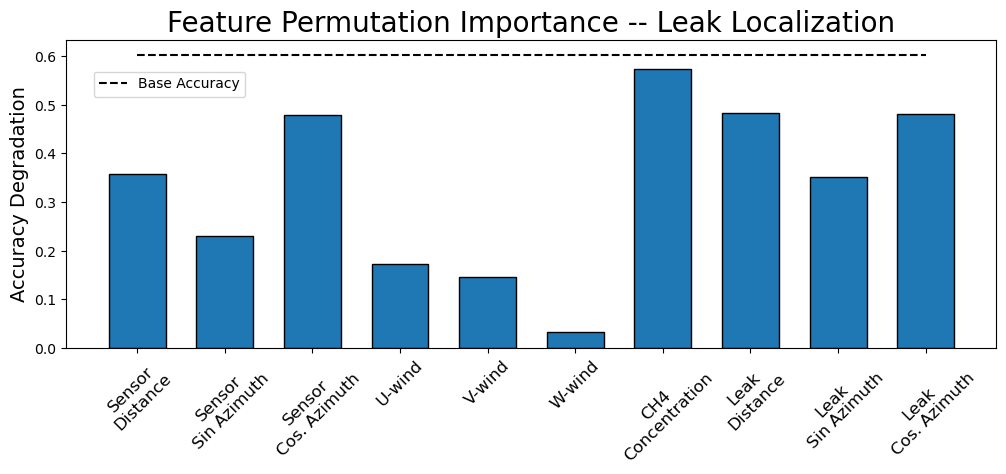

In [17]:
labels = ['Sensor\nDistance', 'Sensor\nSin Azimuth', 'Sensor\nCos. Azimuth', 'U-wind', 'V-wind', 'W-wind', 'CH4\nConcentration', 'Leak\nDistance', 'Leak\n Sin Azimuth', 'Leak\n Cos. Azimuth']
plt.figure(figsize=(12, 4))
plt.bar(acc_diff.keys(), acc_diff.values(), width=0.65, edgecolor='k')
plt.xticks(range(10), labels, rotation=45, fontsize=12)
plt.ylabel('Accuracy Degradation', fontsize=14)
plt.hlines(true_acc, 0, 9, color='k', linestyle="--", label="Base Accuracy")
plt.legend(bbox_to_anchor =(0.2, 0.92))
plt.title("Feature Permutation Importance -- Leak Localization", fontsize=20)
plt.show()

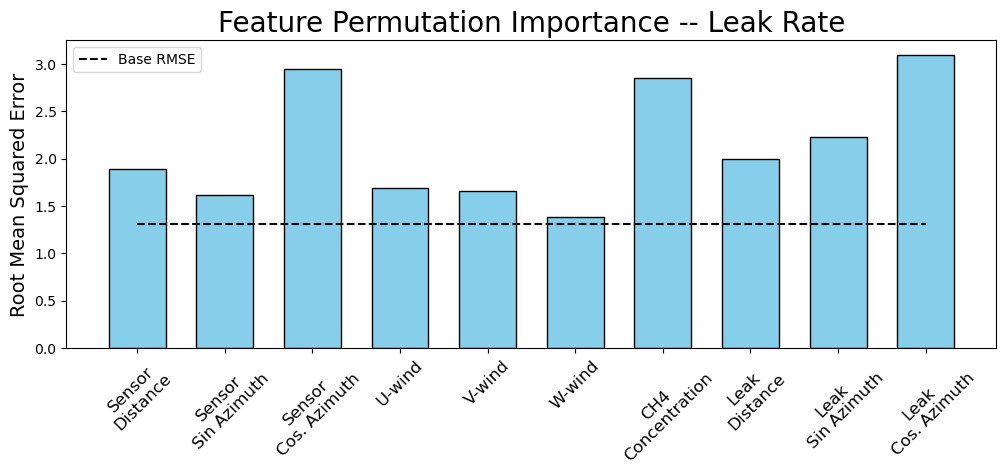

In [18]:
labels = ['Sensor\nDistance', 'Sensor\nSin Azimuth', 'Sensor\nCos. Azimuth', 'U-wind', 'V-wind', 'W-wind', 'CH4\nConcentration', 'Leak\nDistance', 'Leak\n Sin Azimuth', 'Leak\n Cos. Azimuth']
plt.figure(figsize=(12, 4))
plt.bar(rmse_diff.keys(), [np.abs(x) + true_rmse for x in rmse_diff.values()], width=0.65, edgecolor='k', color='skyblue')
plt.xticks(range(10), labels, rotation=45, fontsize=12)
plt.ylabel('Root Mean Squared Error', fontsize=14)
plt.hlines(true_rmse, 0, 9, color='k', linestyle="--", label="Base RMSE")
plt.legend(loc=0)
plt.title("Feature Permutation Importance -- Leak Rate", fontsize=20)
plt.show()